# PRV Assignment 2

- Pablo Garcia Fernández

Initial configuration

In [8]:
# Initial configuration
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

#######################################
## PREDIFINE CONSTATNS OF THE EXERCISE
F = 2406.1 # focal length in pixels 

### 1 - Obtain correspondence points from undistorted images 

In [9]:
def obtain_points(img1_n, img2_n, k=20000, no_matches=8, pintar=False):
    img1 = cv.imread(img1_n, cv.IMREAD_GRAYSCALE) 
    img2 = cv.imread(img2_n, cv.IMREAD_GRAYSCALE)

    sift = cv.SIFT_create(k)
    kp1, des1 = sift.detectAndCompute(img1, None) # q
    kp2, des2 = sift.detectAndCompute(img2, None) # t

    bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = bf.match(des1, des2)
    print(f"Total no. matches: {len(matches)}")
    matches = (sorted(matches, key = lambda x:x.distance))[:no_matches]
    print(f"Keep no. matches: {len(matches)}")
    
    if pintar:
        img3 = cv.drawMatches(img1, kp1, img2, kp2, matches, img2, flags=2)
        plt.imshow(img3)
        plt.savefig(img1_n + img2_n + ".png", dpi=400)
        #plt.show()

    # Get points of the matches https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
    # Each point -> (col, row)
    list_kp1 = [kp1[mat.queryIdx].pt for mat in matches] 
    list_kp2 = [kp2[mat.trainIdx].pt for mat in matches]
    
    return list_kp1, list_kp2

Total no. matches: 12354
Keep no. matches: 8


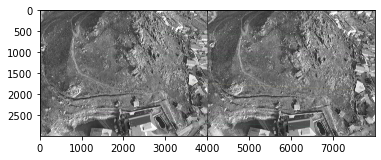

In [10]:
list_kp1, list_kp2 = obtain_points('DJI_0186.jpg', 'DJI_0187.jpg', pintar=True)

In [11]:
list_kp1 = np.array(list_kp1)
list_kp2 = np.array(list_kp2)
print(list_kp1)
print(list_kp2)

[[3550.25219727 1723.578125  ]
 [1606.62695312 1081.48620605]
 [3549.14233398 1734.109375  ]
 [2936.12060547 2638.87133789]
 [2878.02709961  538.82025146]
 [3780.42797852  945.3861084 ]
 [1293.89990234 2443.99658203]
 [1486.73168945 2947.65673828]]
[[3527.32592773 1889.97961426]
 [1544.17456055 1093.74902344]
 [3525.24731445 1900.77001953]
 [2771.70678711 2786.34155273]
 [2903.38623047  615.81744385]
 [3882.265625   1085.19763184]
 [1115.93640137 2432.95776367]
 [1241.10400391 2960.74121094]]


### 2 - Relative orientation 

In [12]:
def conditioning(points):
    """
    Based on https://allstuffon.blogspot.com/2014/03/eight-point-algorithm-for-fundamental.html
    """
    points = points / points[2]
    
    n, d = points.shape
    centroid = np.mean(points, axis=0)
    centered = points - centroid

    meandist = np.mean(np.sqrt(np.sum(centered ** 2)))
    scale = np.sqrt(2)/meandist

    '''
    T = [scale   0   -scale*c(1)
         0     scale -scale*c(2)
         0       0      1      ];
    '''
    T = np.eye(3)
    T[0][0] = scale
    T[1][1] = scale
    T[0][2] = -scale*centroid[0]
    T[1][2] = -scale*centroid[1]

    # Compute normalize points
    newpts = []
    for p in points:
        newpts.append(np.dot(T,p))
    newpts = np.array(newpts)

    return newpts, T


def obtain_3d_coordinates(list_kp1, list_kp2, img1_shape, img2_shape, focal_px):
    list_kp1_final = []
    list_kp2_final = []

    for p1, p2 in zip(list_kp1, list_kp2):
        # La imagen h,w (y,x)
        # Como el (0,0) de la imagen esta arriba a la izq. -> corregimos para que sea abajo izq.
        p1 = np.array([img1_shape[0], 0]) - p1
        p2 = np.array([img2_shape[0], 0]) - p2

        # Translate to h/2, w/2
        p1 = p1 - np.array([img1_shape[1]/2, img1_shape[0]/2])
        p2 = p2 - np.array([img2_shape[1]/2, img2_shape[0]/2])

        # Append c 
        p1 = np.append(p1, focal_px)
        p2 = np.append(p2, focal_px)

        list_kp1_final.append(p1)
        list_kp2_final.append(p2)
    
    return np.array(list_kp1_final), np.array(list_kp2_final)



def relative_orientation(list_kp1, list_kp2, focal_px, img1_shape, img2_shape):

    ## OBTAIN 3D COORDINATES
    print("OBTAIN 3D COORDINATES")
    print(f"h: {img1_shape[1]}, w:{img1_shape[0]}, F: {focal_px}")
    print(f"Ejemplo 2d coordinates \n{list_kp1[0]}, {list_kp2[0]}")
    kp1, kp2 = obtain_3d_coordinates(list_kp1, list_kp2, img1_shape, img2_shape, focal_px)
    print(f"a 3d coordinates:\n({kp1[0][0]}, {kp1[0][1]}, {kp1[0][2]}), ({kp2[0][0]}, {kp2[0][1]}, {kp2[0][2]})\n")


    ## CONDITIONING
    print("CONDITIONING")
    kp1, T1 = conditioning(kp1)
    kp2, T2 = conditioning(kp2)
    print(f"kp1 condicionado: \n{kp1}")
    print(f"\nkp2 condicionado: \n{kp2}\n")
    print(f"T1: \n{T1}")
    print(f"T2: \n{T2}\n")
   
    ## BUILD EQUATION MATRIX
    eq_matrix = []
    for p1, p2 in zip(kp1, kp2):
        # Create ai
        ai = np.array([p2[0] * p1[0],
                    p2[0] * p1[1],
                    p2[0],
                    p2[1] * p1[0],
                    p2[1] * p1[1],
                    p2[1],
                    p1[0],
                    p1[1],
                    1 
        ])
        eq_matrix.append(ai)
    eq_matrix = np.array(eq_matrix)
    print("\nBUILD EQUATION MATRIX")
    print(f"Equation matrix: \n{eq_matrix}")

    ## Solve the system of equations obtaining the SVD of the matrix
    _, _, vt = np.linalg.svd(eq_matrix)
    e_est = vt[-1,:].reshape((3,3))

    # Apply restrictions of the essential matrix: non-zero singular values are equal and the third is zero
    U, d, V = np.linalg.svd(e_est)
    diag_ = np.array([[1,0,0], [0,1,0], [0,0,0]])
    E = U @ diag_ @ V
    
    print(f"\nESSENTIAL MATRIX E CONDITIONED: \n{E}")
    # DECONDITIONING
    E = T2.T @ E @ T1
    print(f"\nESSENTIAL MATRIX E DE-CONDITIONED: \n{E}")

    # OBTAIN U, V FROM E
    U, d, V = np.linalg.svd(E)
    # Obtain 2 solutions for both R and b
    # Auxiliar matrices:
    W = np.array([[0,1,0], [-1,0,0], [0,0,1]])
    Z = np.array([[0,1,0], [-1,0,0], [0,0,0]])
    R1 = U @ W @ V
    R2 = U @ W.T @ V
    b1 = U @ Z @ U.T
    b2 = U @ Z.T @ U.T
    print(f"\nR1:\n {R1}\nR2:\n {R2}\nb1:\n {b1}\nb2:\n {b2}\n")

    return R1, R2, b1, b2
   

img1 = cv.imread('DJI_0186.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('DJI_0187.jpg', cv.IMREAD_GRAYSCALE)

R1, R2, b1, b2 = relative_orientation(list_kp1, list_kp2, F, img1.shape, img2.shape)

OBTAIN 3D COORDINATES
h: 4000, w:3000, F: 2406.1
Ejemplo 2d coordinates 
[3550.25219727 1723.578125  ], [3527.32592773 1889.97961426]
a 3d coordinates:
(-2550.252197265625, -3223.578125, 2406.1), (-2527.325927734375, -3389.9796142578125, 2406.1)

CONDITIONING
kp1 condicionado: 
[[ 0.39782159 -0.0113625   1.        ]
 [-0.44713226 -0.23137991  1.        ]
 [ 0.3973391  -0.00775389  1.        ]
 [ 0.13083964  0.30226929  1.        ]
 [ 0.1055846  -0.41732829  1.        ]
 [ 0.4978861  -0.27801558  1.        ]
 [-0.58308435  0.23549406  1.        ]
 [-0.49925443  0.40807683  1.        ]]

kp2 condicionado: 
[[ 0.40237186  0.01373387  1.        ]
 [-0.42587946 -0.23319496  1.        ]
 [ 0.40150374  0.01708021  1.        ]
 [ 0.08679204  0.29171565  1.        ]
 [ 0.14178717 -0.38141217  1.        ]
 [ 0.5506103  -0.23584693  1.        ]
 [-0.60473057  0.18212347  1.        ]
 [-0.55245507  0.34580086  1.        ]]

T1: 
[[ 1.1081908   0.         -0.71085171]
 [ 0.          1.1081908  -1.1

In [13]:
# TRIANGULATION 
def triangulation(point1, point2, R, b):
    point2 = b @ R @ point2
    triangulation = np.cross(point1, point2) 
    return triangulation

## OBTAIN 3D COORDINATES -> translate to P and append F (see previous cell)
kp1, kp2 = obtain_3d_coordinates(list_kp1, list_kp2, img1.shape, img2.shape, F)

# We take a pair of correspondeces points.
point1 = np.array(kp1[1])
point2 = np.array(kp2[1])

# Perform the triangulation with the 4 possibilities.
tri1 = triangulation(point1, point2, R1, b2)
tri2 = triangulation(point1, point2, R1, b1)
tri3 = triangulation(point1, point2, R2, b2)
tri4 = triangulation(point1, point2, R2, b1)

print(tri1)
print(tri2)
print(tri3)
print(tri4)

########
# Looking at the signs, we can see that the correct one is [11195410.26754472  2517083.69527846  5523151.34800361]
# So the good solution for the relative orientation is achieved with R1 and b2; or R2 and b1.


[11195410.26754472  2517083.69527846  5523151.34800361]
[-11195410.26754472  -2517083.69527846  -5523151.34800361]
[-11195410.26754472  -2517083.69527846  -5523151.34800361]
[11195410.26754472  2517083.69527846  5523151.34800361]
